In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

In [33]:
import numpy as np
import pandas as pd
import scipy.stats as st

In [79]:
import datetime as dt
from datetime import timedelta, date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

last_date_dt = dt.datetime.strptime(last_date, "('%Y-%m-%d',)")

year_ago = last_date_dt - dt.timedelta(days=365)


In [11]:
# Perform a query to retrieve the data and precipitation scores
precip_results = session.query(Measurement.date, Measurement.prcp).\
    filter(func.DATE(Measurement.date) > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_results, columns=['date', 'prcp'])
precip_df.set_index('date', inplace=True)


# Sort the dataframe by date
precip_df.sort_values(by=['date'], inplace=True)
precip_df

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


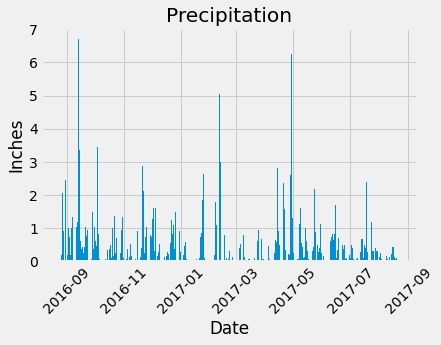

In [12]:
# plot the precitipation data
dates = precip_df.index
x_values = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]
y_values = precip_df["prcp"]

plt.figure()
plt.bar(x_values, y_values)
plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe().round(decimals=2)

,prcp
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
print(f"There are {station_count} stations.")

There are 9 stations.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
active_station = station_activity[0][0]

low_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
high_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()

print(f"Temperature readings for station {active_station}:")
print(f"Lowest temperature: {low_temp[0][0]}")
print(f"Highest temperature: {high_temp[0][0]}")
print(f"Average temperature: {avg_temp[0][0]}")

Temperature readings for station USC00519281:
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


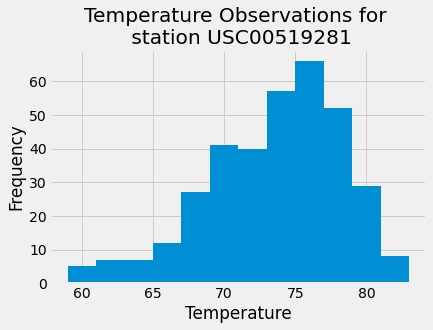

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.tobs).\
    filter(func.DATE(Measurement.date) > year_ago).filter(Measurement.station == active_station).all()

temp_df = pd.DataFrame(temp_results, columns=["tobs"])

plt.hist(temp_df["tobs"], bins=12)
plt.title(f"Temperature Observations for \n station {active_station}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

An unpaired t-test will be used because the datasets are from different groups (two different months).  

In [39]:
# get all June temps from database, put into data frame, and calculate average
june_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "06").all()
june_df = pd.DataFrame(june_temp, columns=["date", "tobs"])
june_avg = june_df["tobs"].mean()

# get all December temps from database, put into data frame, and calculate average
dec_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "12").all()
dec_df = pd.DataFrame(dec_temp, columns=["date", "tobs"])
dec_avg = dec_df["tobs"].mean()

print(f"The average termperature for June is: {june_avg}.")
print(f"The average termperature for December is: {dec_avg}.")

The average termperature for June is: 74.94411764705882.
The average termperature for December is: 71.04152933421226.


In [34]:
# run t-test for June & Dec temps
st.ttest_ind(june_df["tobs"], dec_df["tobs"], equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

### Temperature Analysis II

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_start_date = "2017-06-01"
my_end_date = "2017-06-10"
my_trip = calc_temps(my_start_date, my_end_date)
my_trip_avg = my_trip[0][1]

<function matplotlib.pyplot.show(*args, **kw)>

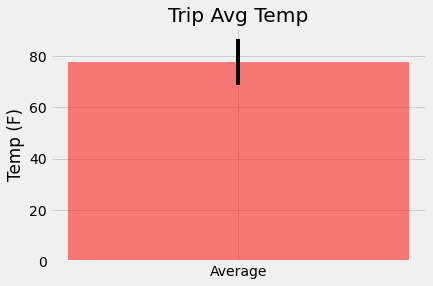

In [70]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_yerr = my_trip[0][2] - my_trip[0][0]

plt.bar("Average", my_trip_avg, color="r", alpha=0.5, yerr=my_trip_yerr)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.show

### Daily Rainfall Average

In [75]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_total = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name,\
                                Station.latitude, Station.longitude, Station.elevation).\
    group_by(Measurement.station).order_by(desc(func.sum(Measurement.prcp))).\
    filter(Measurement.date >= my_start_date).filter(Measurement.date <= my_end_date).\
    filter(Measurement.station == Station.station).all()
rainfall_total

[(0.99,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (0.92,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (0.85,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (0.73, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (0.28,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.06, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [95]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return (session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all())[0]
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [83]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2017, 6, 1)
end_dt = date(2017, 6, 10)

date_list = []
for dt in daterange(start_dt, end_dt):
    date_list.append(dt.strftime("%m-%d"))

date_list

['06-01',
 '06-02',
 '06-03',
 '06-04',
 '06-05',
 '06-06',
 '06-07',
 '06-08',
 '06-09',
 '06-10']

In [96]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []

for day in date_list:
    normals.append(daily_normals(day))

normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0)]

In [98]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
normals_df["date"] = date_list
normals_df.set_index("date", inplace=True)
normals_df

,tmin,tavg,tmax
date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


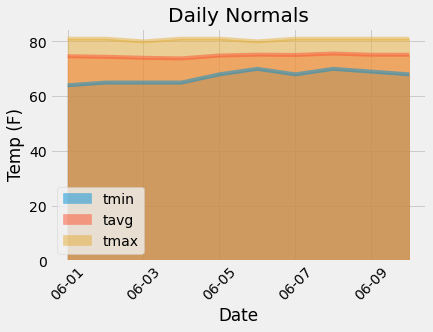

In [106]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.title("Daily Normals")
plt.ylabel("Temp (F)")
plt.xlabel("Date")
plt.show()